# <font color=navy> 4. Markov Chain Monte Carlo Method </font>

## 4.1 Monte Carlo Simulation
- Random sampling을 통해 함수의 값을 확률적으로 계산하는 알고리즘 
- 풀기 어려운 고차원의 적분을 하거나 높은 차원의 최적화 문제를 풀 때 사용 
- 샘플의 수 $n$이 커질수록 정확한 적분값에 가까워짐

### Example: 원주율 계산 
- 한 변의 길이가 1인 정사각형에 원의 1/4을 꼭 맞게 그린다면 원의 넓이 공식에 따라  "사분원의 넓이: 정사각형의 넓이 = $\pi / 4:1$"임을 안다. 무리수 $\pi$가 어떤 값인지 모른다고 할 때 어떻게 $\pi$를 추정할 수 있을까? 
    1. 정사각형 위에 일정 개수($n$)의 점을 균일하게 찍는다. 
    2. $n$개의 점들 중 원의 사분면 안에 떨어지는 점의 개수($x$)를 센다. (즉, $x^2 + y^2<1$을 만족하는 점) 
    3. $x/n \approx \pi/4$이므로 $\pi$를 $x/n\times 4$로 근사한다. 
<img src = "https://upload.wikimedia.org/wikipedia/commons/8/84/Pi_30K.gif" width=400>

### Example: 정규확률변수의 함수의 기대값
- $X$가 $N(0,1)$을 따르는 정규분포라고 하자.  $e^x$의 기대값은 무엇인가? 
- 수리통계 식 해결: 수학적으로 계산하자면 아래의 적분을 풀면 됨
$$ \int_{-\infty}^{\infty} e^x \cdot \frac 1{\sqrt{2\pi}} e^{-\frac {x^2} 2} dx$$ 
- Monte Carlo simulation 

In [10]:
# pymc3 사용 
import pymc3 as pm
import numpy as np
with pm.Model() as model:
    x = pm.Normal('x', 0, 1)
np.mean(np.exp(x.random(size = 10000)))

1.6463136251293218

In [11]:
x.random(size = 10000) #10000개 랜덤추출

array([-0.51395232,  1.28049613, -0.19454231, ...,  2.25116748,
       -0.17325258, -0.84430066])

In [12]:
np.exp(x.random(size = 10000)) # e에 x 승

array([4.19625114, 5.88580091, 1.61715789, ..., 1.24002429, 0.23326218,
       6.4052928 ])

In [13]:
np.mean(np.exp(x.random(size = 10000)))

1.6571331984566893

In [14]:
# scipy 사용 
import scipy.stats as stats
x = stats.norm.rvs(0,1,size = 10000)
np.mean(np.exp(x))

1.6899936674070604

### Example: Bayesian model

- 앞의 예제 들은 샘플을 추출할 분포가 정규분포, 균등분포와 같이 잘 알려져 있어 쉽게 추출할 수 있었다. 
- Recall: Poisson-Exponential 모델 (문자메세지 데이터) 
$$ \lambda_i\sim Unif(0,5) \mbox{ or } \lambda_i\sim Exp(3)  \mbox{ or } \lambda_i \sim Exp(10)$$
$$ C_i| \lambda_i \sim Poisson(\lambda_i) $$

- 베이지안 모형에서 사후분포는 일반적으로 복잡하기 때문에 직접적으로 random sample을 추출하기가 쉽지 않다. 

#### 사전분포 
- 균등 사전분포의 모양 

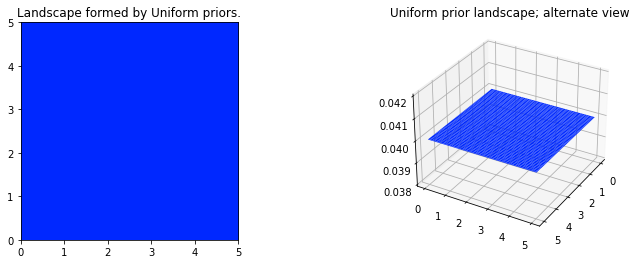

In [16]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");


- 지수 사전분포의 모양 

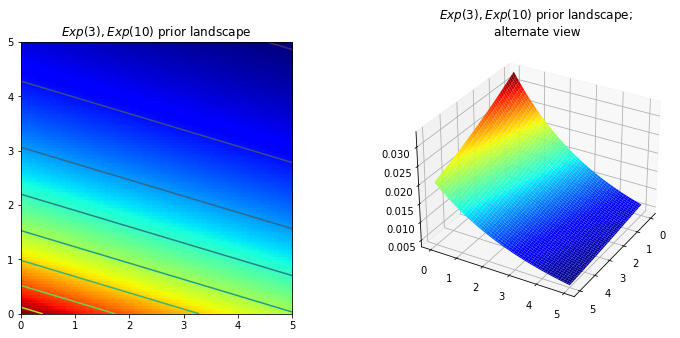

In [17]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

#### $N$개의 관측치로 업데이트 한 사후분포의 모양 

In [21]:
# create the observed data
# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1 # 실제로는 모르지만 밑에 식을 위해 임의로 지정
lambda_2_true = 3 # 실제로는 모르지만 밑에 식을 위해 임의로 지정

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
## posterior = likelihood * prior

x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])


observed (2-dimensional,sample size = 1): [[1 2]]


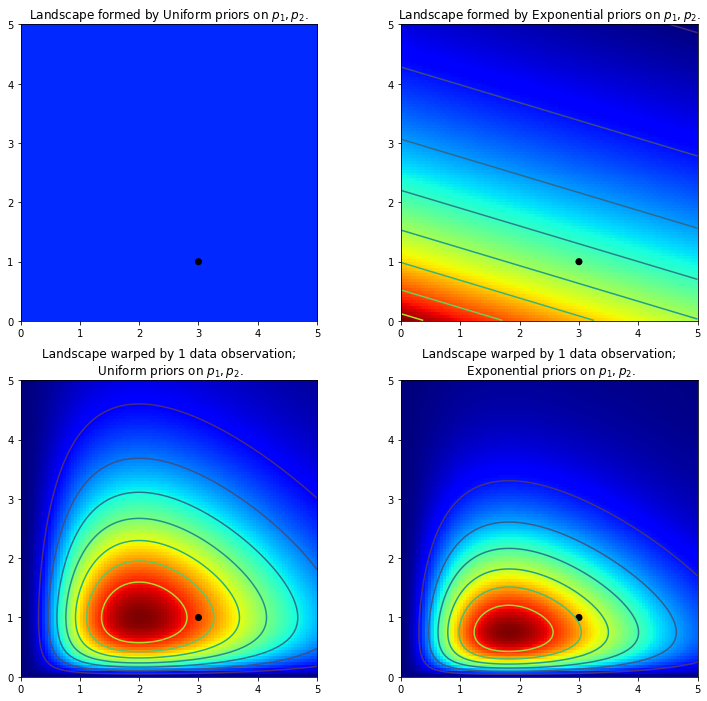

In [22]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :]) #prior
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower', #prior * likelihood
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower', # prior
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L) #prior * likelihood
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);


- 균등 사전분포일 때 관측치 쪽으로 더 기울어진 사후분포를 갖는다. 
- 사전분포가 보다 강한 사전적 믿음을 나타낼 때 (지수 사전분포) 관측치의 영향이 덜하다. 


- 베이지안 모형의 사후분포와 같이 직접 샘플을 추출하기 힘든 경우 사용하는 random sampling 방법으로 **Importance Sampling**, **Rejection Sampling**, **MCMC** 등이 있다.


---

## 4.2. Rejection sampling
- Posterior distribution($p(x)$)에서 샘플 추출이 어렵기 때문에 대신 추출이 용이한 proposal distribution($q(x)$)에서 샘플을 추출하고 추출된 샘플을 적절히 reject/accept 하여 posterior distribution에서 추출된 것과 비슷한 형태를 만드는 것이 목적.
- $q(x)$: Proposal distribution
    - $p(x)$와 $q(x)$는 위치, 분포가 비슷해야 한다. 
    - 상수 $M$에 대해서 $p(x)\leq Mq(x)$를 만족해야 한다. 
    
    
#### Rejection sampling 알고리즘
1. $q(x)$에서 $y$를 생성한다. 
2. Uniform(0,1)에서 $u$를 생성한다. 
3. 만일 $u\leq \frac{p(y)}{Mq(y)}$이면 y를 샘플로 채택, 만일 조건을 만족하지 못하면 기각한다. 
    

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile10.uf.tistory.com%2Fimage%2F99C832365AC9995C0B27FF" width=500>

X0 점에서 나눈 값이 그 점을 포함할지에 대한 확률이다.
- 빨간색에서는 포함될 확률이 약 1, 초록색에서는 0.3 정도인 것

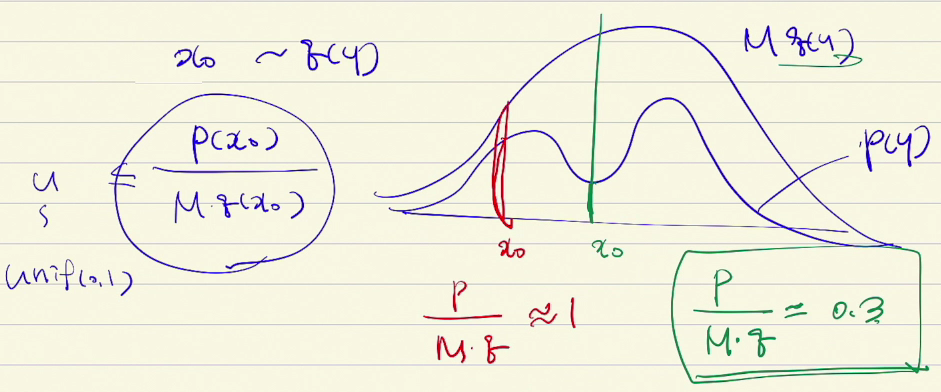

---

## 4.3 Markov Chain Monte Carlo (MCMC)

- 샘플링을 하는 하나의 방법으로써 이전 단계에서 추출된 표본을 기반으로 다음 표본을 순차적으로 추출하는 방법 (독립적인 표본이 아님)
- 차원이 높으면(즉, 적분을 해야 하는 변수의 개수가 많아지면) 샘플링의 수렴속도가 늦어지는 문제를 해결 
    - Curse of Dimensionality (차원의 저주)
    <img src="https://www.researchgate.net/profile/Mahua_Bhattacharya3/publication/264823819/figure/fig1/AS:651533758787592@1532349161929/The-curse-of-dimensionality-a-11-objects-in-one-unit-bin-b-6-objects-in-one-unit-bin_W640.jpg" width=700>
- Metropolis Hasting's method, Gibbs Sampling이 대표적인 방법 
- 분포 자체가 아닌 사후확률분포로부터의 표본을 돌려주는 방법 

###  MCMC의 아이디어 
- 임의의 랜덤 표본에서 시작 
- $i$번째 샘플을 참고하여 $i+1$번째 샘플을 추출

<img src="https://raw.githubusercontent.com/Gwan-Siu/BlogCode/master/other/MCMC.png" width=800>

##### NOTE: Markov Chain 
- 여러 상태(state) $x_1, x_2, ...$가 주어져 있고 $x_i$에서 $x_j$로 이동할 조건부 확률 transition distribution $T(x_j|x_i)$이 주어져 있어 매 step마다 이 확률값에 따라 이동하는 확률과정 (보드게임?)
<img src="http://www.secmem.org/assets/images/mcmc/markov-chain.png" width=400>



### Metropolis-Hasting's (M-H) method 
사후분포에서 어떻게 샘플을 추출하는가? (사후분포 모양의 산 모양을 어렴풋이 추정하기 위해 산이 높을 수록 그 산에서 더 많은 조약돌을 모으는 방식)
#### MH 알고리즘 
1. 특정 현재 위치에서 시작한다. 
2. 현재 위치 주변에서 새로 이동할 위치를 조사한다. (주변의 조약돌을 조사) 
3. 데이터와 사전확률분포에 따라 새로운 위치를 수용할지 안할지 판단한다. (새로운 조약돌이 그 산에서 나올 가능성을 조사) 
4. (a) 수용한다면 새로운 위치로 이동하고 1단계로 이동한다. (새로운 조약돌을 취함)
    (b) 수용하지 않는다면 기존 위치에서 1단계로 이동한다. (새로운 조약돌을 무시)
5. 수많은 반복 후에 모든 가능성 위치를 돌려준다. (모든 조약돌의 위치를 모음)

#### MH 알고리즘 with Random Walk (수학적 표현) 
- Target distribution: $\pi(x)$ - 사후분포
- Proposal distribution: $ N(x^{(t)}, \sigma^2)$


1. 초기값 $x^{(0)}$을 결정한다. 
2. $t=0, 1, ...$에 대하여 다음의 과정을 반복 수행한다. 
    1. $y$를 **random walk** 방법으로 발생시킨다. 
        - $y=x^{(t)}+\epsilon, ~~\epsilon\sim N(0,\sigma^2)$
    2. $u$를 균일분포 $U(0,1)$로부터 발생하여, 다음의 과정을 수행한다. 
    $$ x^{(t+1)} = \left\{ \begin{matrix}
    y,& \mbox{if }u<\alpha(x^{(t)}, y)\\
    x^{(t)}, & \mbox{otherwise}
    \end{matrix}\right. $$
    $$ \alpha(x, y) = \min \left\{ 1, \frac{\pi(y) }{\pi(x)} \right\}: \mbox{Acceptance Probability} $$

- Proposal distribution의 분산에 따라 어떻게 MH의 결과는 달라질까?

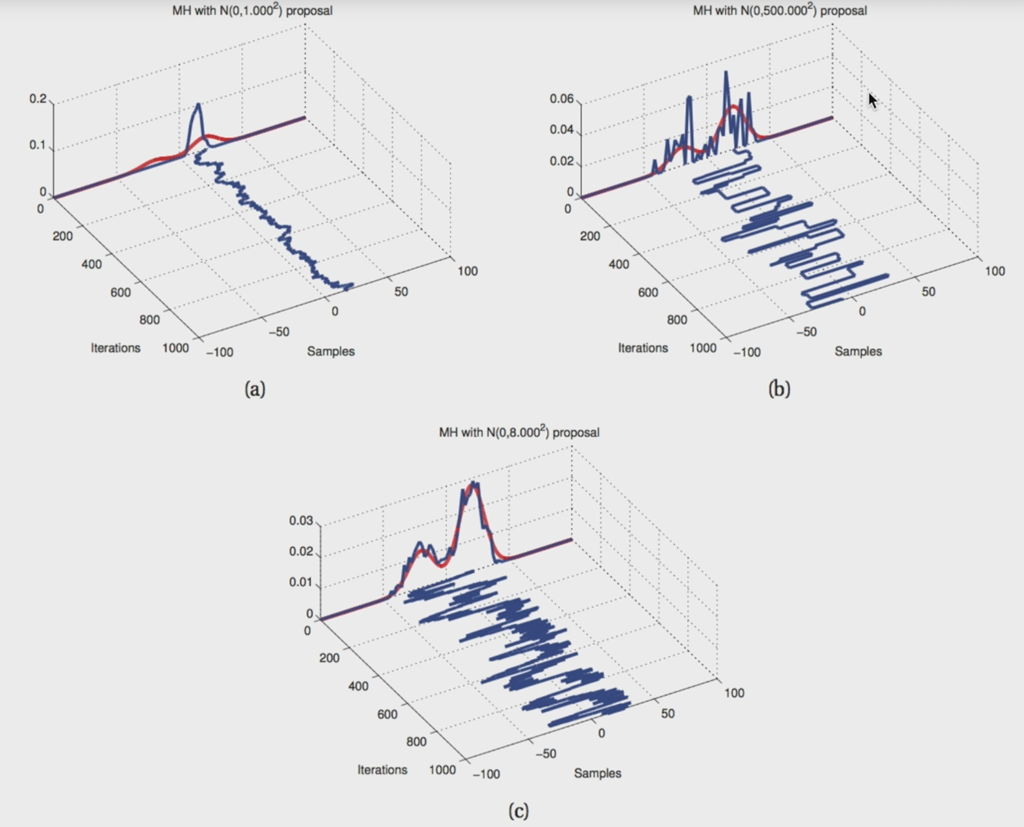

분산이 지나치게 작다면 샘플링이 시작점에서 벗어나지 않아 다른 부분에 대한 탐색을 하기 어렵다. 또한 분산이 너무 크다면 분포에 대해 비슷하게 샘플링을 하지 못할 수 있다.

시그마가 작으면 gradient 느낌\
시그마가 크면 수렴값 못찾는 느낌

- **질문: 초기값에 따라서 같은 값이라도 선택되어 질 확률이 다르다고 생각하는데 이 부분에 대해서는 문제가 없냐???**

### Example: 혼합모델을 사용한 비지도 클러스터링 

다음과 같은 데이터가 주어져있다.

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


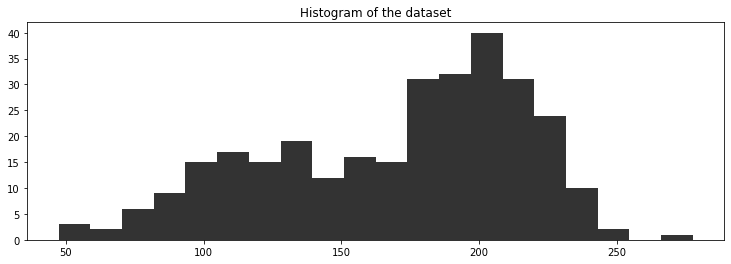

In [23]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")


- 위의 히스토그램을 보면 두 개의 클러스터가 보이고 각 클러스터가 120, 200 근처를 중심으로 하고 있는것으로 추측된다.
- 이를 바탕으로 아래의 모형을 설정한다.  
    1. 각 데이터 포인트에 대해 $p$의 확률로 클러스터 1을 선택하거나 $1-p$의 확률로 클러스터 2를 선택 
    2. 1단계에서 선택한 클러스터($i=1$ or 2)에서  $N(\mu_i, \sigma_i^2)$에서 random sample을 추출
    3. 1과 2를 반복

$$ p \sim Unif(0,1)$$
$$ Z|p \sim Bernoulli(p)$$ 

$$ X|Z,\mu, \sigma \sim \left\{ 
\begin{matrix}
N(\mu_1, \sigma_1^2)  &\mbox{ if } Z=1\\
N(\mu_2, \sigma_2^2)  &\mbox{ if } Z=0
\end{matrix}
\right.$$   

$$\sigma_1\sim Unif(0,100), \sigma_2\sim Unif(0,100)  $$ 
$$\mu_1 \sim N(120,10^2), \mu_2\sim N(190, 10^2) $$



##### Model building

In [25]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1) # p --> Stochastic
    p2 = 1 - p1 # 1-p              --> Determinatic
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0])) # Z
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[1 1 1 1 0 1 0 0 1 1]


In [26]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2) # sigma1, sigma2
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2) # mu1, mu2
    
    center_i = pm.Deterministic('center_i', centers[assignment]) # 해당 카테고리의 mu_i
    sd_i = pm.Deterministic('sd_i', sds[assignment]) # 해당 카테고리의 sigma_i
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data) # X
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])


Random assignments:  [1 1 1 1] ...
Assigned center:  [190. 190. 190. 190.] ...
Assigned standard deviation:  [50. 50. 50. 50.]


##### MH sampling 

In [27]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
#     trace = pm.sample(6250, step=[step1, step2], chains=4, tune=1000)
    trace = pm.sample(25000, step=[step1, step2], chains=1, tune=1000) # tune 초기1000개 버리기

<ipython-input-27-f8e6ade3fecd>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(25000, step=[step1, step2], chains=1, tune=1000) # tune 초기1000개 버리기
Sequential sampling (1 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]


Sampling 1 chain for 1_000 tune and 25_000 draw iterations (1_000 + 25_000 draws total) took 618 seconds.
C:\Users\JangSeongHyun\anaconda3\lib\site-packages\arviz\data\base.py:169: UserWarning: More chains (25000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


In [1]:
6250*4

25000

- 연속형 변수인 $\mu_i, \sigma_i, p$에 대해서는 `Metropolis()` 사용 
- 범주형 변수인 $Z$에 대해서는 `CategoricalGibbsMetropolis()` 사용 
- 두 스텝을 번갈아가며 25000개의 샘플을 추출 
- `chains`: 독립적인 MCMC 샘플링 체인을 몇개로 진행할 것인지 결정. 별도로 지정하지 않으면 CPU의 core 수(maximum = 4) 
- `tune`: 샘플링 초기의 일정량의 샘플을 step size, scaling 등을 tuning하는데 사용하고 삭제한다. default=1000

https://docs.pymc.io/api/inference.html

- `trace`에 모든 PyMC3 변수의 sampling 결과가 저장

In [ ]:
trace.varname # __들어가있는 것은 제외

In [ ]:
trace['centers'].shape

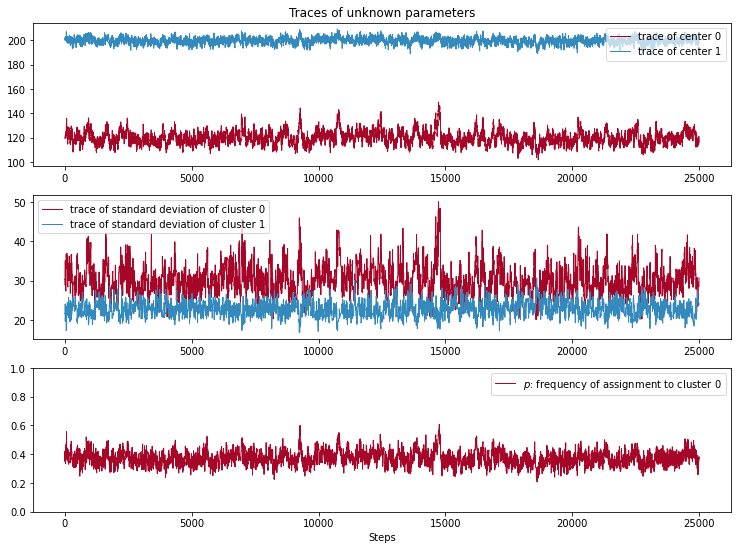

In [19]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();


- 각 모수 샘플의 경로는 수렴한다. 여기서 수렴이란 하나의 점으로 수렴하는 것이 아니라 샘플링 가능한 점들의 **분포(distribution)**로 수렴을 의미한다.
(MCMC 수렴의 의미)
- 처음 수천 개의 점을 사용한 추론은 좋은 아이디어가 아니다. 초기값의 영향이 크게 작용하여 우리가 관심이 있는 최종 분포에 아직 충분히 다다르지 않았을 수도 있다. 그래서 추론용 표본을 사용하기 전에 그 표본들을 버리는 게 좋다. 수렴이전의 이런 기간을 **burn-in period**라고 한다. 

<img src="https://www.researchgate.net/profile/Peter_Gerstoft/publication/3018574/figure/fig6/AS:668313155825668@1536349681451/Full-implementation-of-the-MCMC-algorithm-a-burn-in-and-initial-sampling-phases-in-the_W640.jpg" width=700>


- 경로를 따라 각 위치는 이전 위치와 상관관계를 보인다. 상관성이 있기 때문에 공간을 효율적으로 탐색할 수 있지만 상관성이 너무 높으면 공간을 충분히 탐색하지 않을 수 있다. 



- `trace`에 저장되어 있는 현재 위치에서 시작하여 50000개의 샘플을 더 추출한다. 

In [20]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace, chains = 1, tune=0)
    #trace = pm.sample(12500, step=[step1, step2], trace=trace, chains = 4, tune=0)    

Sequential sampling (1 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]


Sampling 1 chain for 0 tune and 75_000 draw iterations (0 + 75_000 draws total) took 1292 seconds.
/Users/yeojinchung/.pyenv/versions/teaching_lm/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (75000) than draws (3). Passed array should have shape (chains, draws, *shape)
  UserWarning,
Only one chain was sampled, this makes it impossible to run some convergence checks


In [21]:
trace['centers'].shape # 이전 25000 샘플 + 새로 추출한 50000 샘플

(75000, 2)

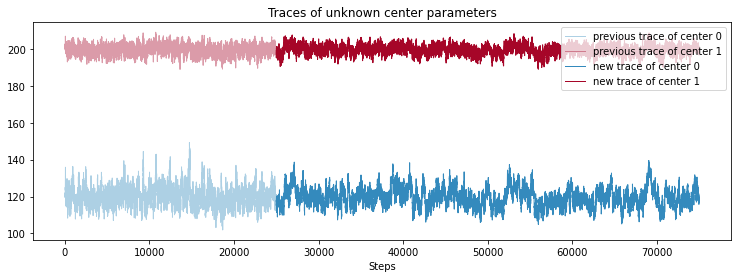

In [22]:
figsize(12.5, 4)
center_trace = trace["centers"][25000:]#수동으로 burning한것(tune)
prev_center_trace = trace["centers"][:25000] #수동으로 burning한것(tune)

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");


In [23]:
trace.varnames

['p_interval__',
 'assignment',
 'sds_interval__',
 'centers',
 'p',
 'sds',
 'center_i',
 'sd_i']

In [24]:
trace['centers'].shape

(75000, 2)

In [25]:
trace['sds'].shape

(75000, 2)

##### Cluster investigation

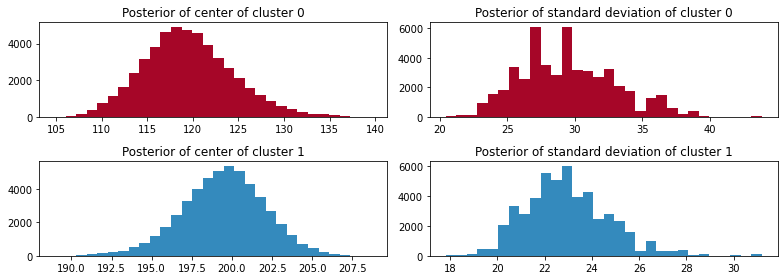

In [26]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()


- 클러스터의 중심이 각 120과 200 근처로 보인다. 


In [27]:
trace['p_interval__'][:3]

array([-0.32363422, -0.43941133, -0.43941133])

In [ ]:
trace['p'].shape

In [28]:
trace['p'][:3]

array([0.41979032, 0.39188125, 0.39188125])

In [29]:
trace['sds_interval__'][:3]

array([[-0.82555781, -1.28681747],
       [-0.82555781, -1.28681747],
       [-0.82555781, -1.28681747]])

In [30]:
trace['sds'][:3]

array([[30.45851655, 21.6391974 ],
       [30.45851655, 21.6391974 ],
       [30.45851655, 21.6391974 ]])

In [31]:
trace["assignment"].shape

(75000, 300)

In [32]:
trace["assignment"][:10] 

array([[0, 1, 1, ..., 1, 1, 0],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1]])

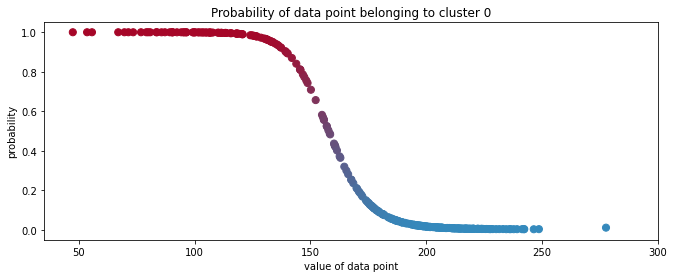

In [33]:
import matplotlib as mpl
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");


In [34]:
assign_trace.mean(axis=0).shape #75000개 평균한게 300개가 있는 것

(300,)

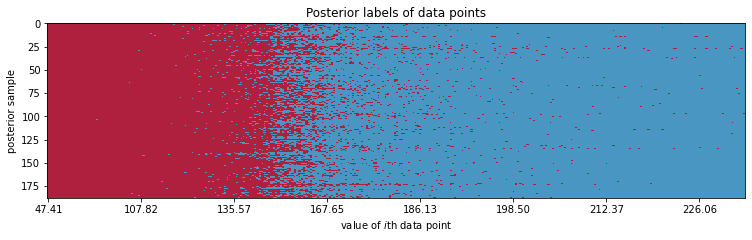

In [35]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=0.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");


- 대부분의 불확실성이 150-170 사이에 나타난다. 


- 각 데이터 포인트에 할당된 클러스터(0 또는 1)을 평균한 그래프를 보면 데이터 값이 150-170 정도 사이일 때 클러스터 할당이 상대적으로 불확실하다. 

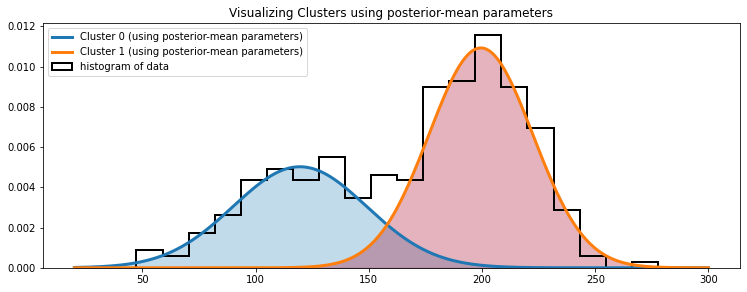

In [36]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", density=True, color="k",
     lw=2, label="histogram of data") #검은색 줄
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])#정규화?
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");


##### Prediction


\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) $$





In [37]:
norm_pdf = stats.norm.pdf
p_trace = trace["p"][25000:]
prev_p_trace = trace["p"][:25000]
x = 175
#    𝑃(𝐿𝑥=0)          𝑃(𝑥=175|𝐿𝑥=0)
v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])
#    𝑃(𝐿𝑥=1)          𝑃(𝑥=175|𝐿𝑥=1)
print("Probability of belonging to cluster 0:", v.mean())

Probability of belonging to cluster 0: 0.00154


In [ ]:
# 위의 175일때 결과는 0번째 집단에 들어갈 확률이 0.00154이다 
#                 즉 1번째 집단에 들어갈 확률은 1-0.00154

In [ ]:
p_trace * norm_pdf(x, loc=center_trace[:,0], scale=std_trace[:,0])

In [ ]:
v.shape

In [ ]:
v[:10] 
# True 라면 0번째 집단에 들어갈 확률이 1번째 집단에 들어갈 확률보다 높다는 것

## 4.4 Diagnosing Convergence

### 자기상관 (Autocorrelation)

- 순차적인 일련의 관측치($\{x_t\}$, $t=$time point)들 간에 존재하는 상관관계를 자기상관이라고 한다.  
- Time $s$일때 값을 알고 있다면 Time $t$의 값을 아는데 도움이 되는가?"의 질문에 yes라면 자기상관이 있는 것
$$R(k) = Corr( x_t, x_{t-k} ) $$
- $k$가 커질수록 자기상관은 일반적으로 작아진다. => 간격이 커지니까 상관관계가 작아진다.

#### Example

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$

which have example paths like:


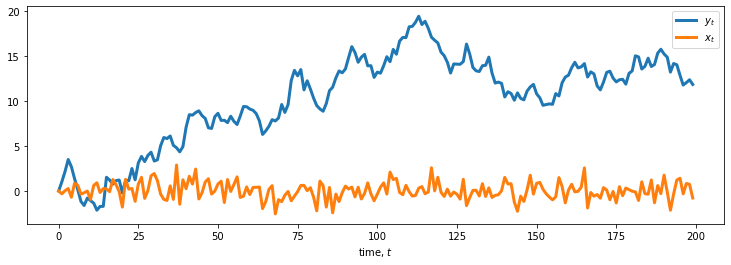

In [33]:
figsize(12.5, 4)

import pymc3 as pm
x_t = np.random.normal(0, 1, 200) # 독립표본
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i - 1], 1) # 자기상관이 있는 표본

plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend();


#### MCMC와 자기상관 
- MCMC의 알고리즘은 현재 샘플 값을 바탕으로 다음 샘플을 추출하는 방법이기 때문에 자기상관이 존재할 수 밖에 없다
- MCMC 결과로 추출된 샘플의 **자기상관이 높다면 사후분포의 평면을 충분히 탐색하지 못한다.**
- 자기상관계수를 관찰함으로써 MCMC의 수렴을 판단할 수 있다. 

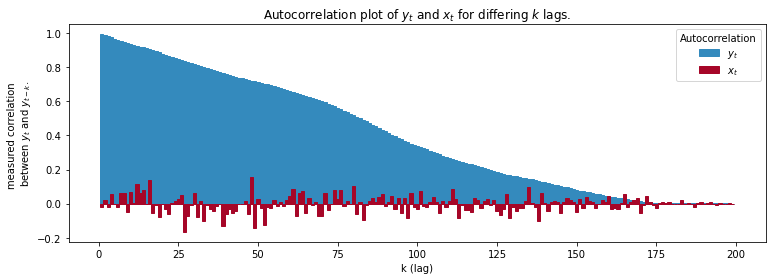

In [34]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full') 
    result = result / np.max(result)
    return result[result.size // 2:]

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");


### Thinning
- 샘플링된 표본으로 이후에 적용하게 될 많은 알고리즘은 독립적인 표본을 필요로 하지만  MCMC에 의한 샘플링은 자기상관이 존재한다. 
- 매 n번째 표본을 선택함으로써 자기상관을 줄이는 방법을 사용\
=>건너뛰기를 한다는 것


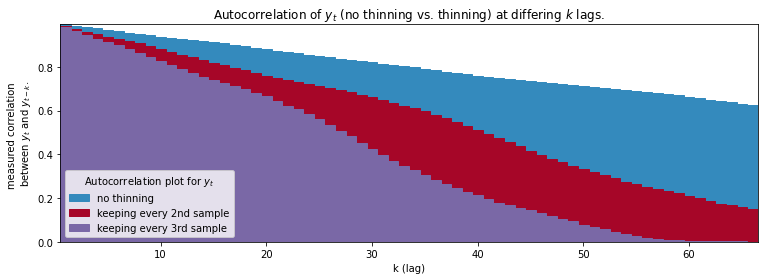

In [35]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");

- Thinning을 하는 간격인 $n$을 크게 할수록 자기상관은 빠르게 줄어든다. 
- 하지만 더 많은 샘플링을 필요로 하므로 시간이 오래걸린다. 
    - $n=10$으로 thinning 하여 10,000개 샘플을 만들려면 100,000개 샘플링이 필요 
- 보통 10 이하의 thinning으로 사용 


### `pymc3.plots`

- 위의 내용에서는 설명을 위해 히스토그램, 자기상관계수 등의 그래프를 직접 그렸지만 실제 분석시에는 `pymc3.plots` 모듈을 활용하여 편하게 그릴 수 있다.


In [42]:
trace['centers'].shape

(75000, 2)

In [43]:
trace.varnames

['p_interval__',
 'assignment',
 'sds_interval__',
 'centers',
 'p',
 'sds',
 'center_i',
 'sd_i']

/Users/yeojinchung/.pyenv/versions/teaching_lm/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/yeojinchung/.pyenv/versions/teaching_lm/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (75000) than draws (3). Passed array should have shape (chains, draws, *shape)
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126855890>,
      dtype=object)

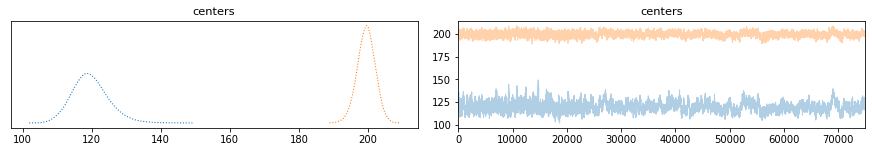

In [48]:
pm.plots.traceplot(trace, var_names=["centers"])


- $\mu_1, \mu_2$의 사후분포에서 추출된 75000개 샘플의 density 
    - 120, 200을 중심으로 각 클러스터 센터가 분포
- 75000개 샘플의 trace

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1328ad7d0>],
      dtype=object)

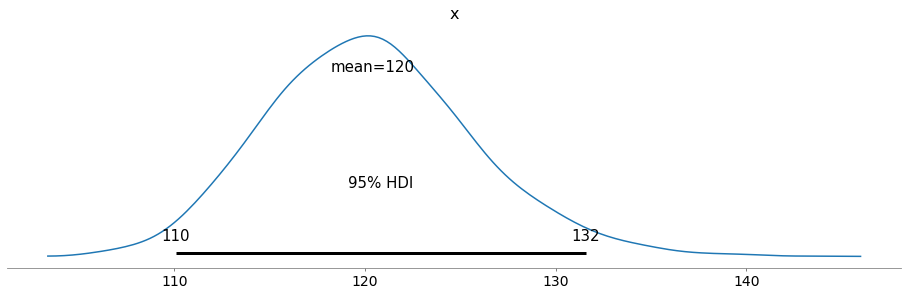

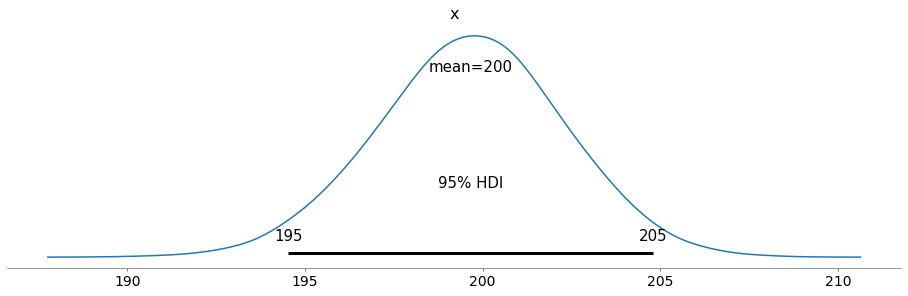

In [38]:
pm.plots.plot_posterior(trace["centers"][:,0], hdi_prob = 0.95)
pm.plots.plot_posterior(trace["centers"][:,1], hdi_prob = 0.95)

- $\mu_1, \mu_2$의 Posterior mean
    - 75000개 샘플의 평균값 
- 95% credible interval (highest posterior density interval; HDI) 가로로 자르는 방식
    - $\mu_1, \mu_2$가 95%의 **확률**로 포함되는 구간 (비교: 95% confidence interval(세로로 자르는 방식)는 가능성이라고 말해야하기 때문에 비슷하지만 다른 개념)

/Users/yeojinchung/.pyenv/versions/teaching_lm/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/yeojinchung/.pyenv/versions/teaching_lm/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (75000) than draws (3). Passed array should have shape (chains, draws, *shape)
  UserWarning,


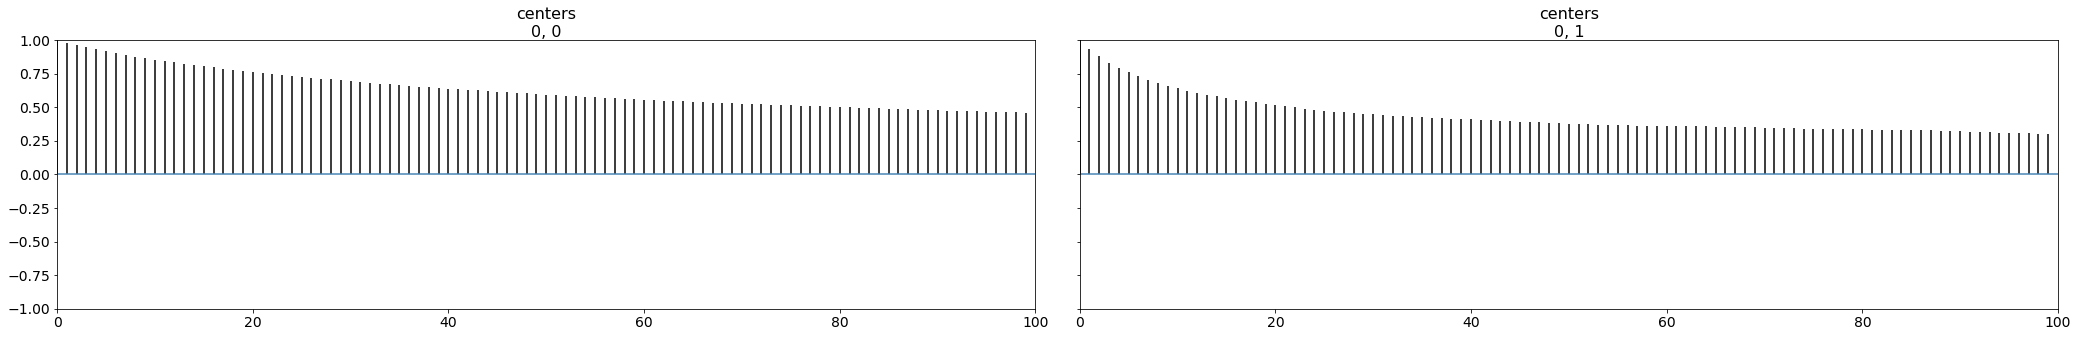

In [39]:
pm.plots.autocorrplot(trace, var_names=["centers"]);

- 위에서 그린 것과 같은 Autocorrelation plot 


## 4.4 MCMC에서 유용한 팁
### Starting value의 선택
- 샘플링을 할 때 마다 크게 다른 결과가 나온다면 MCMC가 충분히 수렴하지 않았다는 의미 
- 무한개의 샘플을 추출한다면 이론적으로 사후분포에 수렴하겠지만 이는 불가능하다.
- MCMC의 시작을 사후분포와 가까운 초기값에서 시작하는게 효율적인 수렴을 가능하게 한다.

#### 방법1: Frequentist의 추정값 
- Frequentist의 추정값을 초기값으로 사용
- Example: 데이터가 정규분포로부터 나왔다고 가정하는 모형에서 $\mu$를 추정한다면 데이터의 평균값을 초기값으로 사용 

        mu = pm.Uniform( "mu", 0, 100, testval = data.mean() )

#### 방법2: Maximum a posterior (MAP)

- 사후분포 곡면의 산꼭대기(**MAP**)에 가까운 곳에서 시작한다면 빠르게 사후분포로부터 샘플링이 가능 
-  `find_MAP` 함수 사용 
    - `Model()` context 안에서 정의하여 MAP를 계산하여  `pm.sample()`의 `start` 옵션에서 사용

            start = pm.find_MAP()
            trace = pm.sample(2000, step=pm.Metropolis, start=start)

    - 최적화 방법을 사용하여 log-posterior 함수의 최대값을 어림잡는다.
        - Default: Broyden-Fletcher-Goldfarb-Shanno ([BFGS](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm)) 알고리즘

